### Dataset

In [1]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

intensities, sizes = {}, {}
for which in ["train", "test"]:
    intensities[which], sizes[which] = [], []
    root_dir = f"/home/esuekei/Documents/Git/inr_segmentation/data/RAVIR Dataset/{which if which == 'test' else which+'/training_images'}"
    for fpath in os.listdir(root_dir):
        # Assuming test_image is loaded as a torch tensor and moved to device
        test_image = cv2.imread(f"{root_dir}/{fpath}", cv2.IMREAD_GRAYSCALE)
        intensities[which].extend(list(test_image.ravel()))
        sizes[which].append(f"{test_image.shape[0]}x{test_image.shape[1]}")

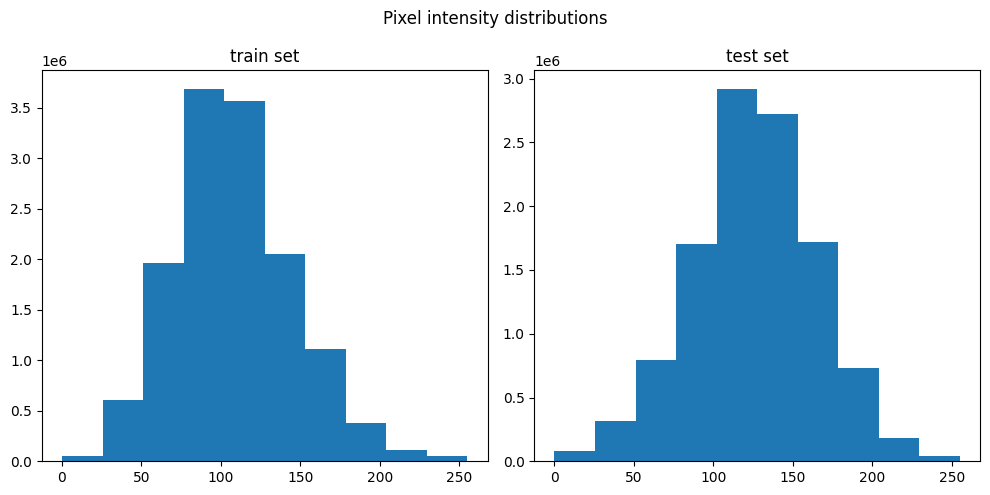

In [2]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

for ax, which in zip(axs, ["train", "test"]):
    ax.hist(intensities[which])
    ax.set_title(f"{which} set")

fig.suptitle("Pixel intensity distributions")
fig.tight_layout()

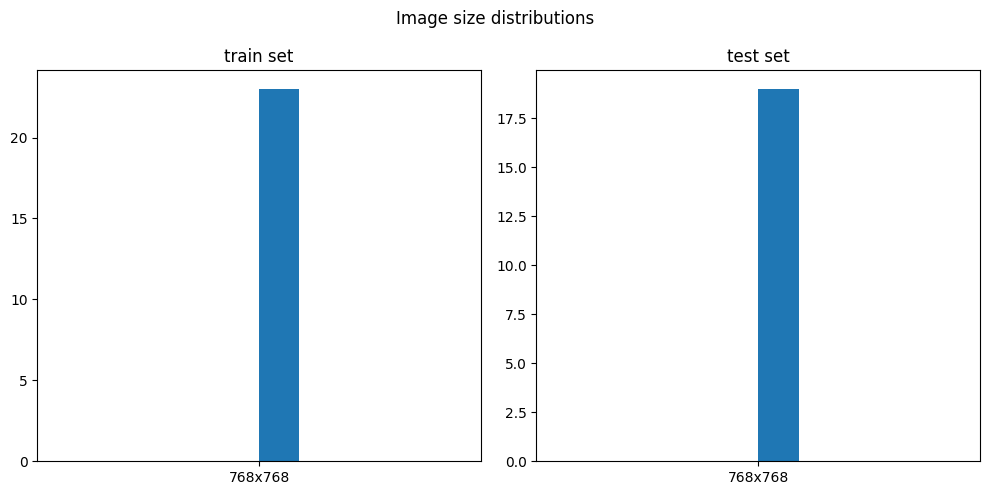

In [3]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

for ax, which in zip(axs, ["train", "test"]):
    ax.hist(sizes[which])
    ax.set_title(f"{which} set")

fig.suptitle("Image size distributions")
fig.tight_layout()

### Dataloader

In [67]:
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, target_size=(256, 256)):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.target_size = target_size  # Target size for resizing

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_path, self.image_files[idx])
        mask_path = os.path.join(self.masks_path, self.mask_files[idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    # Assuming masks are also grayscale

        if self.target_size is not None:
            # Resize image and mask to target size
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) # this should help maintaining the connectivity on the mask
            
        # Normalize image to range [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Transform mask values from 0, 128, 256 to 0, 1, 2
        mask = self.transform_mask(mask)

        # Generate all coordinates and their corresponding intensities and labels
        coords_intensities, labels = self.generate_all_coordinates_intensities_and_labels(image, mask)

        return coords_intensities, labels

    def transform_mask(self, mask):
        mask_transformed = np.zeros_like(mask)
        mask_transformed[mask == 0] = 0
        mask_transformed[mask == 128] = 1
        mask_transformed[mask == 255] = 2

        return mask_transformed

    def generate_all_coordinates_intensities_and_labels(self, image, mask):
        H, W = image.shape
        
        # Create a grid of coordinates
        y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
        coords = np.stack((y_coords, x_coords), axis=-1).reshape(-1, 2)
        
        # Normalize coordinates to range [0, 1]
        coords = coords.astype(np.float32) / np.array([H, W], dtype=np.float32)
        
        # Flatten image and mask to get corresponding intensities and labels
        intensities = image.flatten()
        labels = mask.flatten()
        
        # Combine coordinates and intensities
        coords_intensities = np.hstack([coords, intensities.reshape(-1, 1)])
        
        # Convert to tensors
        coords_intensities = torch.tensor(coords_intensities, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        
        return coords_intensities, labels


In [68]:
from torch.utils.data import DataLoader

# Define paths to your image and mask directories
images_path = '/home/esuekei/Documents/Git/inr_segmentation/data/RAVIR Dataset/train/training_images' #'path/to/images'
masks_path = '/home/esuekei/Documents/Git/inr_segmentation/data/RAVIR Dataset/train/training_masks' #'path/to/masks'

# Create dataset and dataloader
batch_size = 4    # Adjust based on your GPU memory

dataset = SegmentationDataset(images_path, masks_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

coords_intensities, sampled_labels = next(iter(dataloader))
print(coords_intensities.shape, sampled_labels.shape)

torch.Size([4, 65536, 3]) torch.Size([4, 65536])


### Model implementation

#### Define the Network

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies
        x = x.unsqueeze(-1) * frequencies.unsqueeze(0).unsqueeze(0)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        return x.view(x.shape[0], -1)

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=5, num_freqs=10):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)
        self.mlp = nn.ModuleList()
        input_dim = num_freqs * 2 * 2 + 1  # 2 for (x, y) and 2 for sin/cos, 1 for intensity

        self.mlp.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.mlp.append(nn.Linear(hidden_dim, hidden_dim))
        self.mlp.append(nn.Linear(hidden_dim, num_classes))

    def forward(self, coords_intensities):
        bs, ns, _ = coords_intensities.size()
        coords, intensities = coords_intensities[:, :, :-1], coords_intensities[:, :, -1].view((bs, ns,1))
        x = self.pos_enc(coords).view((bs, ns, -1))
        x = torch.cat([x, intensities], dim=-1)
        for layer in self.mlp[:-1]:
            x = F.relu(layer(x))
        x = self.mlp[-1](x)
        return x # Return logits without activation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### Define the Loss

In [17]:
import torch.nn.functional as F

class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(MultiClassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert class indices to one-hot encoding
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
        # Apply softmax to get probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Flatten the inputs and targets for each class
        inputs = inputs.view(-1, self.num_classes)
        targets_one_hot = targets_one_hot.view(-1, self.num_classes)
        
        # Compute the intersection and union for each class
        intersection = (inputs * targets_one_hot).sum(dim=0)
        union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
        # Compute the Dice coefficient for each class
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Average Dice coefficient across classes
        dice_loss = 1 - dice.mean()
        
        return dice_loss

#### Training

In [80]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define your model
num_classes = 3 
model = INRSegmentationModel(num_classes=num_classes).to(device)

# Use AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Define your loss function
criterion = MultiClassDiceLoss(num_classes) # nn.CrossEntropyLoss()

# Define the cosine annealing learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # To store the loss of each epoch
    for batch in dataloader:
        coords_intensities, labels = batch
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(coords_intensities)
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)

    # Step the scheduler
    scheduler.step()

    if epoch == 0 or (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/1000], Loss: 0.7404
Epoch [50/1000], Loss: 0.5527
Epoch [100/1000], Loss: 0.5393
Epoch [150/1000], Loss: 0.5328
Epoch [200/1000], Loss: 0.5183
Epoch [250/1000], Loss: 0.4970
Epoch [300/1000], Loss: 0.4907
Epoch [350/1000], Loss: 0.4933
Epoch [400/1000], Loss: 0.4869
Epoch [450/1000], Loss: 0.4784
Epoch [500/1000], Loss: 0.4716
Epoch [550/1000], Loss: 0.4795
Epoch [600/1000], Loss: 0.4775
Epoch [650/1000], Loss: 0.4667
Epoch [700/1000], Loss: 0.4628
Epoch [750/1000], Loss: 0.4660
Epoch [800/1000], Loss: 0.4756
Epoch [850/1000], Loss: 0.4655
Epoch [900/1000], Loss: 0.4561
Epoch [950/1000], Loss: 0.4620
Epoch [1000/1000], Loss: 0.4639


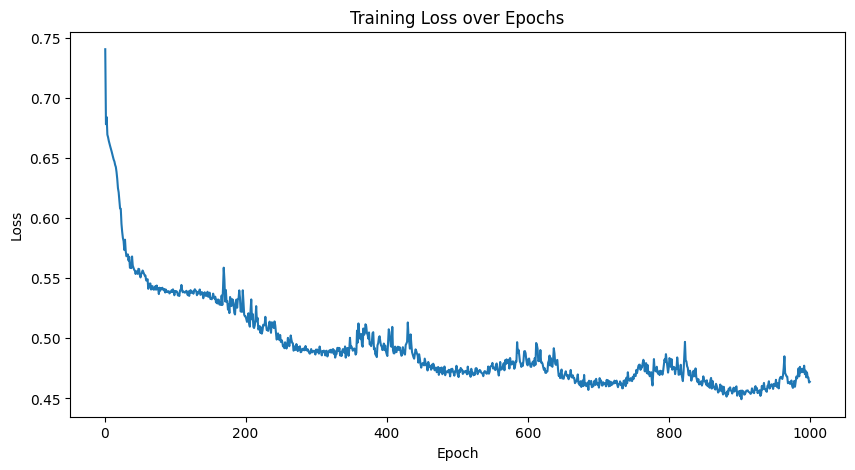

In [81]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

#### Step 4: Inference

In [84]:
def visualize_segmentation_mask(mask, title):
    """
    Visualizes the segmentation mask using Matplotlib.
    
    Args:
    mask (numpy.ndarray): 2D array of shape (H, W) with values 0, 1, or 2
    """
    # Define color mapping
    color_mapping = {
        0: [255, 255, 255], # White
        1: [0, 0, 255],     # Blue
        2: [255, 0, 0]      # Red
    }

    # Create an RGB image from the mask
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_value, color in color_mapping.items():
        rgb_image[mask == class_value] = color

    # Normalize the RGB values to the range [0, 1] for matplotlib
    rgb_image = rgb_image / 255.0

    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide the axes
    plt.title(title)

def evaluate_model(model, coords_intensities, labels, img_size):
    model.eval()  # Set model to evaluation mode
    
    coords_intensities, labels = coords_intensities.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(coords_intensities.unsqueeze(0))
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))

        predicted_mask = outputs.argmax(dim=-1).view(img_size).cpu().numpy()  # Get the class with the highest score

    # Plot the ground truth and predicted masks side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    visualize_segmentation_mask(labels.view(img_size).cpu().numpy(), title="Ground Truth")

    plt.subplot(1, 2, 2)
    visualize_segmentation_mask(predicted_mask, title=f"Predicted Mask (DiceLoss = {loss.item():.3f})")
    
    plt.show()

### Inference at training resolution

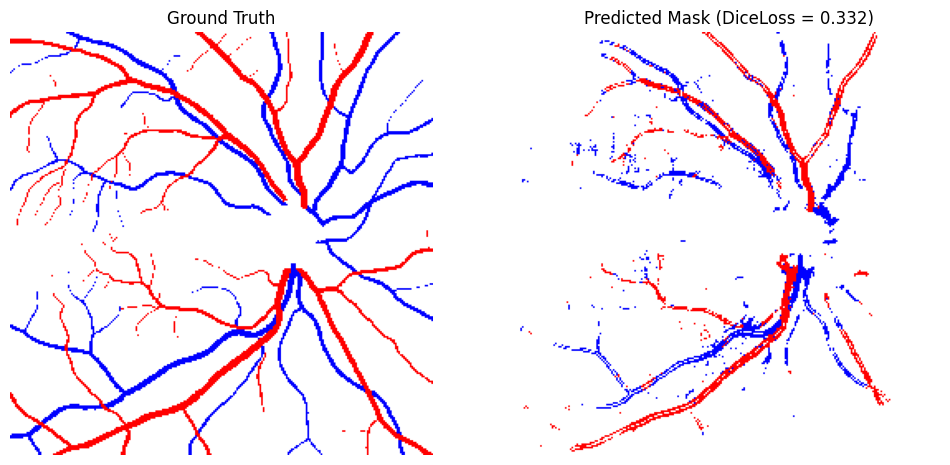

In [86]:
eg_img, eg_mask = dataset[0]
evaluate_model(model, eg_img, eg_mask, img_size=(256, 256))

### Inference at different resolution

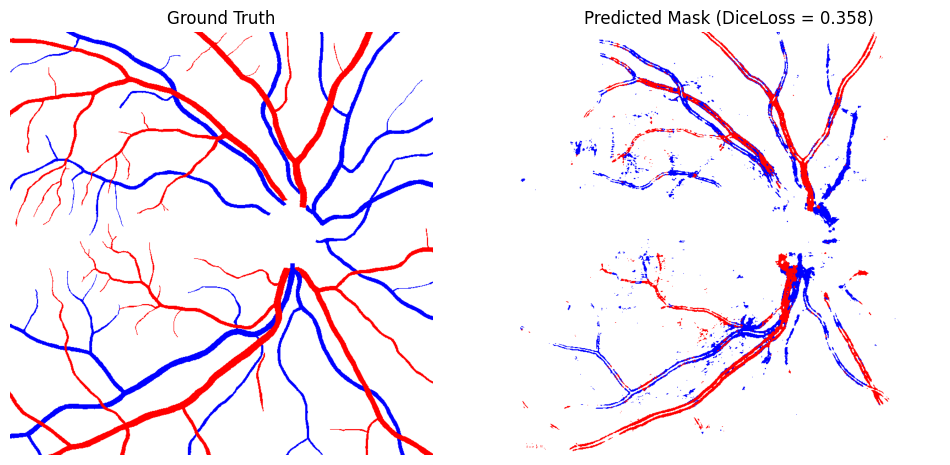

In [87]:
orig_size_dataset = SegmentationDataset(images_path, masks_path, target_size=None) # we try to predict on the non-reduced images
eg_img, eg_mask = orig_size_dataset[0]
evaluate_model(model, eg_img, eg_mask, img_size=(768, 768))